In [1]:
pip install opencv-python numpy scikit-image


  Using cached numpy-2.2.6-cp311-cp311-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.2.6-cp311-cp311-win_amd64.whl (12.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.4.0
    Uninstalling numpy-2.4.0:
      Successfully uninstalled numpy-2.4.0
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
crewai-tools 1.6.0 requires crewai==1.6.0, but you have crewai 1.6.1 which is incompatible.
datasets 4.4.1 requires fsspec[http]<=2025.10.0,>=2023.1.0, but you have fsspec 2025.12.0 which is incompatible.
transformers 4.57.3 requires huggingface-hub<1.0,>=0.34.0, but you have huggingface-hub 1.2.3 which is incompatible.


In [ ]:
import cv2
import numpy as np
from skimage.measure import label, regionprops
from scipy.spatial.distance import euclidean

# Load & binarize image
img = cv2.imread(r"F:\owM2g.png", 0)
_, bw = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)


labels = label(bw)
regions = regionprops(labels)


def desc(r):
    h = r.bbox[2] - r.bbox[0]
    w = r.bbox[3] - r.bbox[1]
    return np.array([h, w])

features = [desc(r) for r in regions]

THRESHOLD = 6   


groups = []
used = set()

for i, f1 in enumerate(features):
    if i in used: continue
    g = [i]; used.add(i)
    for j, f2 in enumerate(features):
        if j not in used and euclidean(f1, f2) < THRESHOLD:
            g.append(j); used.add(j)
    groups.append(g)


out = np.zeros_like(bw)
for g in groups:
    proto = regions[g[0]]
    for i in g:
        r = regions[i]
        out[r.bbox[0]:r.bbox[2], r.bbox[1]:r.bbox[3]] = \
            cv2.resize(
                bw[proto.bbox[0]:proto.bbox[2], proto.bbox[1]:proto.bbox[3]],
                (r.bbox[3]-r.bbox[1], r.bbox[2]-r.bbox[0]),
                cv2.INTER_NEAREST
            )

cv2.imshow("Result", out)
cv2.waitKey(0)


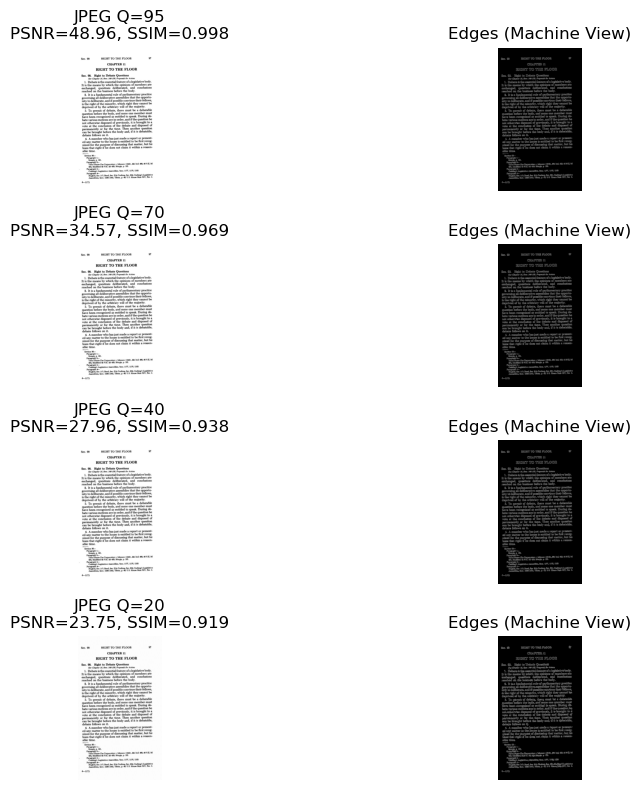

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# ---------- 1. Load grayscale image ----------
img = cv2.imread(r"F:\j.jpg", cv2.IMREAD_GRAYSCALE)
assert img is not None, "Image not found!"

# JPEG quality levels
qualities = [95, 70, 40, 20]

results = []

# ---------- 2. Compress, evaluate, process ----------
for q in qualities:
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), q]
    _, enc = cv2.imencode(".jpg", img, encode_param)
    comp = cv2.imdecode(enc, cv2.IMREAD_GRAYSCALE)

    # ---------- 3. Metrics ----------
    psnr = peak_signal_noise_ratio(img, comp, data_range=255)
    ssim = structural_similarity(img, comp, data_range=255)

    # ---------- 4. Edge detection (machine-relevant) ----------
    edges = cv2.Canny(comp, 100, 200)

    results.append((q, psnr, ssim, comp, edges))

# ---------- 5. Visualization ----------
plt.figure(figsize=(12, 8))

for i, (q, psnr, ssim, comp, edges) in enumerate(results):
    plt.subplot(4, 2, 2*i+1)
    plt.imshow(comp, cmap='gray')
    plt.title(f"JPEG Q={q}\nPSNR={psnr:.2f}, SSIM={ssim:.3f}")
    plt.axis("off")

    plt.subplot(4, 2, 2*i+2)
    plt.imshow(edges, cmap='gray')
    plt.title("Edges (Machine View)")
    plt.axis("off")

plt.tight_layout()
plt.show()


Lossless components: 1
Lossy components: 1
SSIM Score: 0.965852361750931


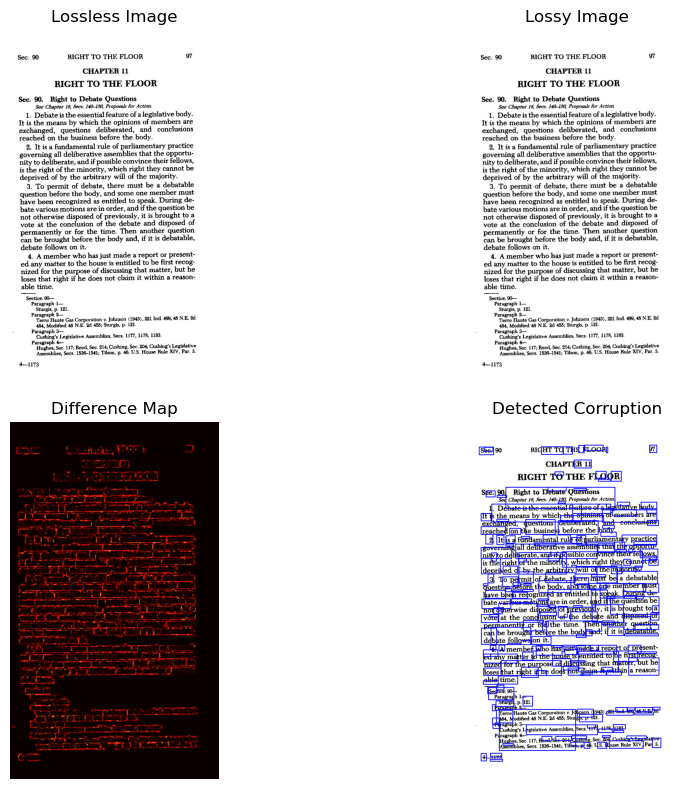

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# ---------------------------
# Load images
# ---------------------------
img_lossless = cv2.imread(r"F:\j.jpg", cv2.IMREAD_GRAYSCALE)
img_lossy = cv2.imread(r"F:\j (1).jpg", cv2.IMREAD_GRAYSCALE)

# Resize if needed (ensure same size)
img_lossy = cv2.resize(img_lossy, (img_lossless.shape[1], img_lossless.shape[0]))

# ---------------------------
# Preprocessing
# ---------------------------
_, bin1 = cv2.threshold(img_lossless, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
_, bin2 = cv2.threshold(img_lossy, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# ---------------------------
# Extract connected components (contours)
# ---------------------------
contours1, _ = cv2.findContours(bin1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours2, _ = cv2.findContours(bin2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print("Lossless components:", len(contours1))
print("Lossy components:", len(contours2))

# ---------------------------
# Structural Similarity (SSIM)
# ---------------------------
score, diff = ssim(img_lossless, img_lossy, full=True)
diff = (1 - diff) * 255
diff = diff.astype("uint8")

print("SSIM Score:", score)

# ---------------------------
# Threshold difference image
# ---------------------------
_, diff_thresh = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)

# ---------------------------
# Find corrupted regions
# ---------------------------
diff_contours, _ = cv2.findContours(diff_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

output = cv2.cvtColor(img_lossless, cv2.COLOR_GRAY2BGR)

for cnt in diff_contours:
    if cv2.contourArea(cnt) > 50:  # ignore noise
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 0, 255), 2)

# ---------------------------
# Display results
# ---------------------------
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.title("Lossless Image")
plt.imshow(img_lossless, cmap='gray')
plt.axis("off")

plt.subplot(2, 2, 2)
plt.title("Lossy Image")
plt.imshow(img_lossy, cmap='gray')
plt.axis("off")

plt.subplot(2, 2, 3)
plt.title("Difference Map")
plt.imshow(diff, cmap='hot')
plt.axis("off")

plt.subplot(2, 2, 4)
plt.title("Detected Corruption")
plt.imshow(output)
plt.axis("off")

plt.tight_layout()
plt.show()
